In [1]:
from DecisionScienceFramework.utils import DistFinder
from DecisionScienceFramework.decision import Decision

C:\Users\perus\AppData\Local\Continuum\Anaconda3\envs\botworks\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Finding parameters for an asymmetric distribution given a 90% CI

This is helpful when an expert will give you a 90% CI and a mean for a particular distribution, and you need to infer its parmeters.  This finds the optimum through a simple hill climbing method.

Optimization terminated successfully.
         Current function value: 0.565085
         Iterations: 82
         Function evaluations: 160
The fit parameters for this lognormal are mu: 0.9068750292439196, s: 0.8554886568419438 
The fit distribution has a mean of 3.5708563830681457 and a 90% CI of (0.6063617093991157, 10.115092842435686).


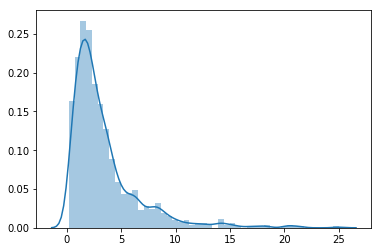

In [2]:
from DecisionScienceFramework.utils import DistFinder
finder = DistFinder(lower=0, upper=10, ev=4, dist='Lognormal')
params = finder.optimize()
finder.summary()
finder.plot_fit()

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 38
         Function evaluations: 71
The fit parameters for this beta are alpha: 0.9999593309435575, beta: 0.9999879257547469
The fit distribution has a mean of 0.49999285110867453 and a 90% CI of (0.04999449675007655, 0.9499998267848907).


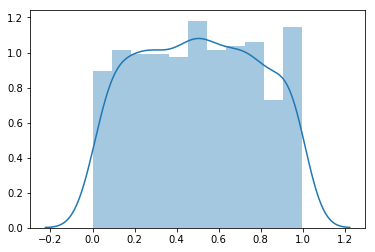

In [3]:
finder = DistFinder(lower=0.05, upper=.95, ev=.5, dist='Beta')
params = finder.optimize()
finder.summary()
finder.plot_fit()

# Building a decision

In [2]:
# Initialize the decision object with a name and fp where we'll save our progress
school_decision = Decision("School Decision", fp="C:\\Users\\perus\\GitHub\\Decision-Science-Framework")

## Recreating the Decision Model sample

In this decision we are choosing between two different recruitment strategies.  We might either hire new staff to actively recuit folks through different engagement strategies, or we could employ a digital media strategy that doesn't actually require more staff but has costs involved in purchasing the service.

The base cost for either strategy is $1,000,000.  For each strategy we then want to consider the probability that we are over/under budget and the effictiveness of either strategy.

In [3]:
# For the hiring strategy, we consider the distribution that we are over/under the base 
# cost.  So in this case, we might be $20,000 under or $400,000 over.
school_decision.add_variable_from_ci("HiringCostOver", lower=-100000, upper=400000, dist="Normal")
# We also want to capture their effectiveness
school_decision.add_variable_from_ci("HiringEffectiveness", lower=30, upper=300, mode=80, dist="Lognormal")

Optimization terminated successfully.
         Current function value: 569.337410
         Iterations: 105
         Function evaluations: 202


In [4]:
# Okay, now we want to create similar variables but for the digital marketing strategy
school_decision.add_variable_from_ci("MarketingCostOver", lower=-20000, upper=80000, dist="Normal")
school_decision.add_variable_from_ci("MarketingEffectiveness", lower=45, upper=90, mode=60, dist="Lognormal")

Optimization terminated successfully.
         Current function value: 16.394315
         Iterations: 88
         Function evaluations: 173


In [5]:
# Now that we've established costs and effectiveness, we just need to add someway to translate
# the number of additional ACMs recruited to a monetary value 
school_decision.add_variable_from_ci("ACMValueAdd", lower=3000, upper=48000, mode=9200, dist='Lognormal')

Optimization terminated successfully.
         Current function value: 17309836.200198
         Iterations: 127
         Function evaluations: 248


In [103]:
# These are the last of our random variables.  Before defining any further deterministic variables,
# like the loss function, we will need to sample.
school_decision.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
C:\Users\perus\AppData\Local\Continuum\Anaconda3\envs\botworks\lib\site-packages\pymc3\model.py:384: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if not np.issubdtype(var.dtype, float):
Sequential sampling (2 chains in 1 job)
NUTS: [ACMValueAdd_log__, MarketingEffectiveness_log__, MarketingCostOver, HiringEffectiveness_log__, HiringCostOver]
100%|█████████████████████████████████████████████████████████████████████████████| 5500/5500 [00:07<00:00, 705.51it/s]


In [104]:
school_decision.add_variable_from_patsy("HireCost", "-1000000 - HiringCostOver")
school_decision.add_variable_from_patsy("HireBenefit", "ACMValueAdd * HiringEffectiveness")
school_decision.add_variable_from_patsy("HireNet", "HireCost + HireBenefit")

In [105]:
school_decision.add_variable_from_patsy("MarketingCost", "-1000000 - MarketingCostOver")
school_decision.add_variable_from_patsy("MarketingBenefit", "ACMValueAdd * MarketingEffectiveness")
school_decision.add_variable_from_patsy("MarketingNet", "MarketingCost + MarketingBenefit")

In [106]:
# Negative -> Hire 
school_decision.set_loss("MarketingNet - HireNet")

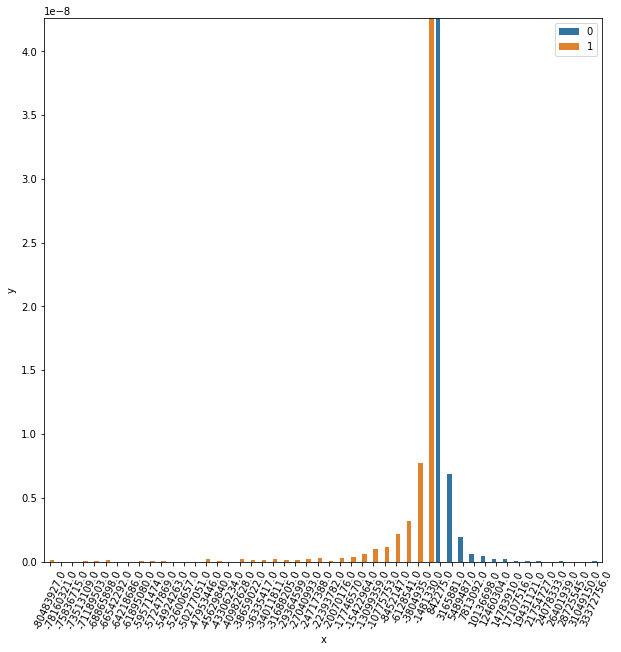

In [107]:
school_decision.plot_loss()

In [108]:
school_decision.deterministic

{'HireBenefit': 'ACMValueAdd * HiringEffectiveness',
 'HireCost': '-1000000 - HiringCostOver',
 'HireNet': 'HireCost + HireBenefit',
 'MarketingBenefit': 'ACMValueAdd * MarketingEffectiveness',
 'MarketingCost': '-1000000 - MarketingCostOver',
 'MarketingNet': 'MarketingCost + MarketingBenefit',
 'loss': 'MarketingNet - HireNet'}

In [124]:
import patsy 
import numpy as np

def calculate_info_value(run_data, column):
    baseline_uncertainty = run_data['loss'].mean()
    mu = run_data[column].mean()
    fixed = run_data.copy()
    fixed[column] = mu
    for key, item in school_decision.deterministic.items():
        var = patsy.dmatrix(f"I({item}) - 1", data=fixed)
        fixed[key] = np.asarray(var)
    updated_uncertainty = fixed['loss'].mean()
    return updated_uncertainty - baseline_uncertainty

In [130]:
calculate_info_value(school_decision.last_run, "MarketingEffectiveness")

4567.347467365646

In [133]:
for column in school_decision.random.keys():
    print(f"{column}: {calculate_info_value(school_decision.last_run, column)}")

HiringCostOver: 1.2223608791828156e-09
HiringEffectiveness: -10891.982026117214
MarketingCostOver: -2.066371962428093e-09
MarketingEffectiveness: 4567.347467365646
ACMValueAdd: -6324.634558762598


In [127]:
school_decision.last_run

,HiringCostOver,MarketingCostOver,HiringEffectiveness,MarketingEffectiveness,ACMValueAdd,HireCost,HireBenefit,HireNet,MarketingCost,MarketingBenefit,MarketingNet,loss
0,196320.633174,23069.358671,232.612310,48.357729,739.727947,-1.196321e+06,1.720698e+05,-1.024251e+06,-1.023069e+06,3.577156e+04,-9.872978e+05,3.695301e+04
1,133373.576950,34073.672267,24.243349,92.678883,14713.722413,-1.133374e+06,3.567099e+05,-7.766637e+05,-1.034074e+06,1.363651e+06,3.295777e+05,1.106241e+06
2,254745.584791,-2311.068372,121.954574,42.427838,1900.820130,-1.254746e+06,2.318137e+05,-1.022932e+06,-9.976889e+05,8.064769e+04,-9.170412e+05,1.058906e+05
3,69141.922495,65562.902989,49.507746,99.000676,6766.101557,-1.069142e+06,3.349744e+05,-7.341675e+05,-1.065563e+06,6.698486e+05,-3.957143e+05,3.384532e+05
4,-105313.236195,19266.004124,46.960105,73.572815,7906.741408,-8.946868e+05,3.713014e+05,-5.233854e+05,-1.019266e+06,5.817212e+05,-4.375448e+05,8.584058e+04
5,102286.625830,21874.669887,119.688599,51.083207,1383.763075,-1.102287e+06,1.656207e+05,-9.366660e+05,-1.021875e+06,7.068706e+04,-9.511876e+05,-1.452165e+04
6,114045.915148,23525.090562,239.180833,66.925221,798.205897,-1.114046e+06,1.909156e+05,-9.231304e+05,-1.023525e+06,5.342011e+04,-9.701050e+05,-4.697462e+04
7,208503.265129,10851.531859,15.891858,56.303394,14752.893197,-1.208503e+06,2.344509e+05,-9.740524e+05,-1.010852e+06,8.306380e+05,-1.802136e+05,7.938388e+05
8,30527.742771,33730.645922,37.221962,67.115860,341.754109,-1.030528e+06,1.272076e+04,-1.017807e+06,-1.033731e+06,2.293712e+04,-1.010794e+06,7.013459e+03
9,212746.307381,-16306.259343,45.039953,58.926381,18268.449528,-1.212746e+06,8.228101e+05,-3.899362e+05,-9.836937e+05,1.076494e+06,9.279988e+04,4.827361e+05


In [116]:
fixed.loss.mean()

-251310.60329062963

In [117]:
school_decision.last_run.loss.mean()

-251310.60329063085

In [112]:
school_decision.last_run.loss.mean()

-251310.60329063085

In [14]:
school_decision.last_run.loss.std()

5144533.42696141

In [ ]:
school_decision.last_run

In [55]:
def get_interval(alpha, samples):
    loss_vec = samples.sort_values('loss', ascending=True).loss
    min_ix = int(loss_vec.shape[0]*alpha)
    max_ix = int(loss_vec.shape[0]*(1-alpha))
    return loss_vec.iloc[min_ix], loss_vec.iloc[max_ix]  

In [57]:
get_interval(0.05, school_decision.last_run)

(-1901594.7774178819, 1073680.9680925482)

In [13]:
from IPython.display import display

In [68]:
print(school_decision.model)
for key, value in school_decision.deterministic.items():
    print(f"{key} ~ {value}")

HireCost ~ -1000000 - HiringCostOver
HireBenefit ~ ACMValueAdd * HiringEffectiveness
HireNet ~ HireCost + HireBenefit
MarketingCost ~ -1000000 - MarketingCostOver
MarketingBenefit ~ ACMValueAdd * MarketingEffectiveness
MarketingNet ~ MarketingCost + MarketingBenefit
loss ~ MarketingNet - HireNet


In [91]:
import pymc3 as pm

In [92]:
with pm.Model() as model:
    a = pm.Normal('normal', 0, 1)

In [97]:
a._repr_latex_()

'$\\text{normal} \\sim \\text{Normal}(\\mathit{mu}=0,~\\mathit{sd}=1.0)$'

In [66]:
latex.print_latex(-1000000 - symbols('HiringCostOver'))

AttributeError: 'function' object has no attribute 'print_latex'

In [30]:
school_decision.last_run.describe().T

,count,mean,std,min,25%,50%,75%,max
HiringCostOver,20000.0,1.494783e+05,1.507187e+05,-4.224385e+05,4.736981e+04,1.485519e+05,2.509453e+05,7.516089e+05
MarketingCostOver,20000.0,3.016936e+04,3.033645e+04,-8.153780e+04,9.926722e+03,3.003319e+04,5.058411e+04,1.618400e+05
HiringEffectiveness,20000.0,9.067715e+01,1.169034e+02,8.621550e-01,2.626795e+01,5.344623e+01,1.080282e+02,2.224367e+03
MarketingEffectiveness,20000.0,6.327090e+01,1.422402e+01,2.367672e+01,5.319564e+01,6.179010e+01,7.155541e+01,1.565850e+02
ACMValueAdd,20000.0,1.225697e+04,3.629009e+04,3.804718e+00,1.235725e+03,3.539653e+03,1.019323e+04,1.414300e+06
HireCost,20000.0,-1.149478e+06,1.507187e+05,-1.751609e+06,-1.250945e+06,-1.148552e+06,-1.047370e+06,-5.775615e+05
HireBenefit,20000.0,1.128185e+06,6.522648e+06,1.147818e+02,5.281246e+04,1.879704e+05,6.614469e+05,5.068131e+08
HireNet,20000.0,-2.129313e+04,6.525100e+06,-1.694334e+06,-1.092558e+06,-9.080531e+05,-4.691491e+05,5.057387e+08
MarketingCost,20000.0,-1.030169e+06,3.033645e+04,-1.161840e+06,-1.050584e+06,-1.030033e+06,-1.009927e+06,-9.184622e+05
MarketingBenefit,20000.0,7.702155e+05,2.260667e+06,1.882299e+02,7.520206e+04,2.175128e+05,6.364291e+05,7.426833e+07
